In [1]:
%load_ext autoreload
%autoreload 2
from gn4pions.modules.nn_functions import * 
from livelossplot import PlotLossesKeras

In [ ]:
# df = load_data(file_path = "../data/onetrack_multicluster/pion_files_old/*.npy", 
#                n_files=10)

In [ ]:
# n_files = 10
# files = glob.glob("../data/onetrack_multicluster/pion_files_old/*.npy")
# df_mariel = pd.concat([pd.DataFrame(np.load(file, allow_pickle=True).item()) for file in tqdm(files[:n_files])])
# print("Dataframe has {:,} events.".format(df_mariel.shape[0]))

In [ ]:
# df = df_mariel[["cluster_E", "deltaR", "dR_pass"]]
# track_pt = df_mariel.trackPt.explode()
# track_eta = df_mariel.trackEta.explode()
# truth_particle_e = df_mariel.truthPartE.explode()
# df["track_pt"] = track_pt
# df["track_eta"] = track_eta
# df["truth_particle_e"] = truth_particle_e
# df = df.explode(column=["cluster_E", "deltaR", "dR_pass"])
# df.dR_pass.astype('bool')
# df = df[df.dR_pass]
# df.reset_index(inplace=True)
# df = df.astype('float')

In [ ]:
# df['log10_cluster_e'] = np.log10(df.cluster_E)
# df['log10_track_pt'] = np.log10(df.track_pt)
# df['log10_truth_particle_e'] = np.log10(df.truth_particle_e)

In [ ]:
# # recreate EM
# train_vars = ['log10_cluster_e_0',]
# target_var = ['log10_cluster_calib_e_0']

In [ ]:
# # recreate track resolution
# train_vars = ['log10_track_pt', 
# #               'track_eta'
#              ]
# target_var = ['log10_truth_particle_pt']

In [20]:
### Load Russell's files 
x = np.load("../data/onetrack_multicluster/pion_files_russell/X_STMC_v2_10_files.npy")
y = np.load("../data/onetrack_multicluster/pion_files_russell/Y_STMC_v2_10_files.npy")

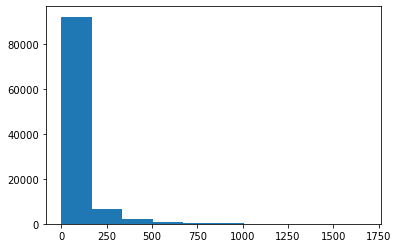

In [21]:
plt.hist(x[:,0,0], bins=10);

In [22]:
info = np.zeros((x.shape[0], 10)) 

for event in tqdm(range(x.shape[0])):
    cluster_inds = np.where(x[event,:,4] == 0.) 
    log10_cluster_e_0 = np.log10(x[event,cluster_inds,0][0,0])
    info[event, 0] = log10_cluster_e_0
    
    log10_cluster_e_1 = np.log10(x[event,cluster_inds,0][0,1])
    info[event, 8] = log10_cluster_e_1
    
    log10_cluster_e_2 = np.log10(x[event,cluster_inds,0][0,2])
    info[event, 9] = log10_cluster_e_2
    
    track_inds = np.where(x[event,:,4] == 1.) # track node indices ("is_track == True")
    if len(track_inds[0]) < 6: 
        continue
    log10_track_pt =  np.log10(x[event, track_inds, 0][0,0])
    track_eta_0 = x[event, track_inds, 1][0,0]
    track_eta_1 = x[event, track_inds, 1][0,1]
    track_eta_2 = x[event, track_inds, 1][0,2]
    track_eta_3 = x[event, track_inds, 1][0,3]
    track_eta_4 = x[event, track_inds, 1][0,4]
    track_eta_5 = x[event, track_inds, 1][0,5]
    
    info[event, 1] = log10_track_pt
    info[event, 2] = track_eta_0
    info[event, 3] = track_eta_1
    info[event, 4] = track_eta_2
    info[event, 5] = track_eta_3
    info[event, 6] = track_eta_4
    info[event, 7] = track_eta_5

  0%|          | 0/102844 [00:00<?, ?it/s]/tmp/ipykernel_23869/1003564294.py:8: RuntimeWarning: divide by zero encountered in log10
  log10_cluster_e_1 = np.log10(x[event,cluster_inds,0][0,1])
/tmp/ipykernel_23869/1003564294.py:11: RuntimeWarning: divide by zero encountered in log10
  log10_cluster_e_2 = np.log10(x[event,cluster_inds,0][0,2])
100%|██████████| 102844/102844 [00:06<00:00, 15267.30it/s]


In [23]:
df = pd.DataFrame(info, columns = ["log10_cluster_e_0", "log10_track_pt", "track_eta_0", "track_eta_1", 
                                   "track_eta_2", "track_eta_3", "track_eta_4", "track_eta_5", 
                                  "log10_cluster_e_1", "log10_cluster_e_2"])
df["log10_truth_particle_e"] = np.log10(y[:,0])
df["log10_cluster_calib_e"] = np.log10(y[:,2])

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.fillna(0)

/tmp/ipykernel_23869/3010664409.py:5: RuntimeWarning: divide by zero encountered in log10
  df["log10_cluster_calib_e"] = np.log10(y[:,2])


In [24]:
df = df[10**(df.log10_cluster_e_0) > 0.5]
df = df[10**(df.log10_cluster_e_1) > 0.5]
df = df[10**(df.log10_cluster_e_2) > 0.5]

In [25]:
df.shape

(52723, 12)

In [26]:
df.keys()

Index(['log10_cluster_e_0', 'log10_track_pt', 'track_eta_0', 'track_eta_1',
       'track_eta_2', 'track_eta_3', 'track_eta_4', 'track_eta_5',
       'log10_cluster_e_1', 'log10_cluster_e_2', 'log10_truth_particle_e',
       'log10_cluster_calib_e'],
      dtype='object')

In [27]:
np.mean(10**df.log10_cluster_e_0/10**df.log10_truth_particle_e)

0.1865697169156273

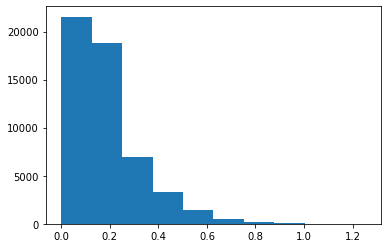

In [28]:
plt.hist(10**df.log10_cluster_e_0/10**df.log10_truth_particle_e);

In [29]:
np.mean((10**df.log10_cluster_e_0+10**df.log10_cluster_e_1+10**df.log10_cluster_e_2)/10**df.log10_truth_particle_e)

0.2631790017384587

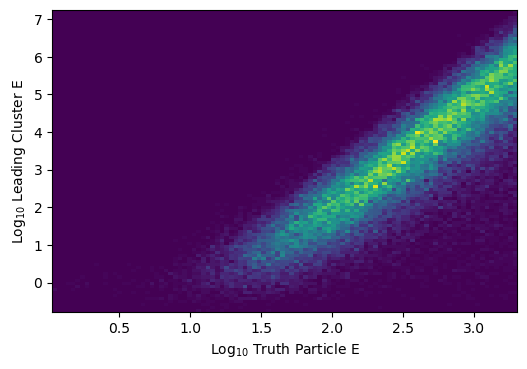

In [30]:
plt.figure(dpi=100)
plt.hist2d(df.log10_truth_particle_e, df.log10_cluster_e_0+df.log10_cluster_e_1+df.log10_cluster_e_2, bins=100);
plt.xlabel(r'Log$_{10}$ Truth Particle E');
plt.ylabel(r'Log$_{10}$ Leading Cluster E');

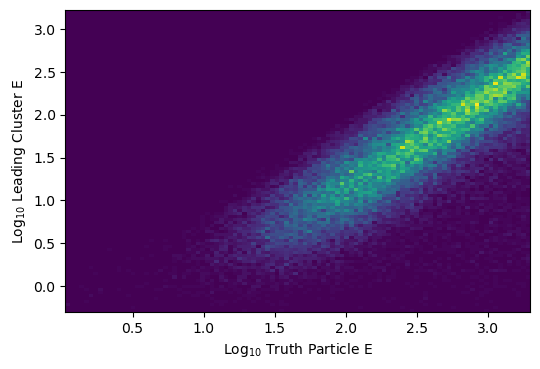

In [31]:
plt.figure(dpi=100)
plt.hist2d(df.log10_truth_particle_e, df.log10_cluster_e_0, bins=100);
plt.xlabel(r'Log$_{10}$ Truth Particle E');
plt.ylabel(r'Log$_{10}$ Leading Cluster E');

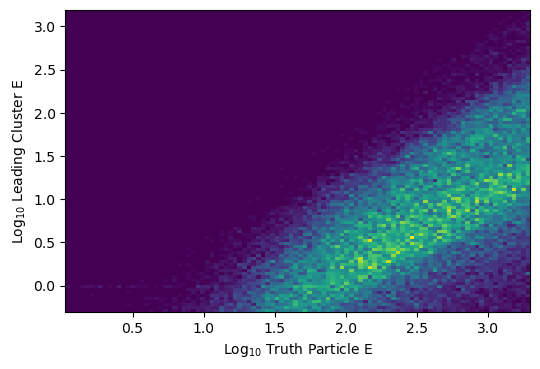

In [32]:
plt.figure(dpi=100)
plt.hist2d(df.log10_truth_particle_e, df.log10_cluster_e_1, bins=100);
plt.xlabel(r'Log$_{10}$ Truth Particle E');
plt.ylabel(r'Log$_{10}$ Leading Cluster E');

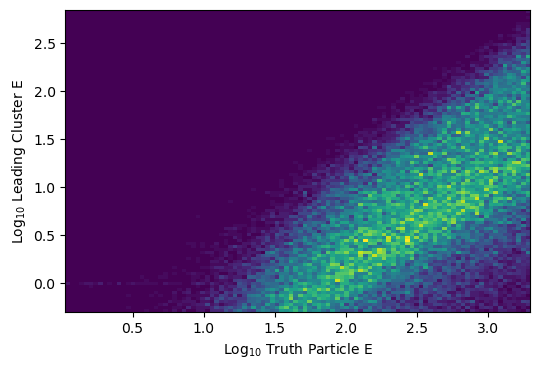

In [33]:
plt.figure(dpi=100)
plt.hist2d(df.log10_truth_particle_e, df.log10_cluster_e_2, bins=100);
plt.xlabel(r'Log$_{10}$ Truth Particle E');
plt.ylabel(r'Log$_{10}$ Leading Cluster E');

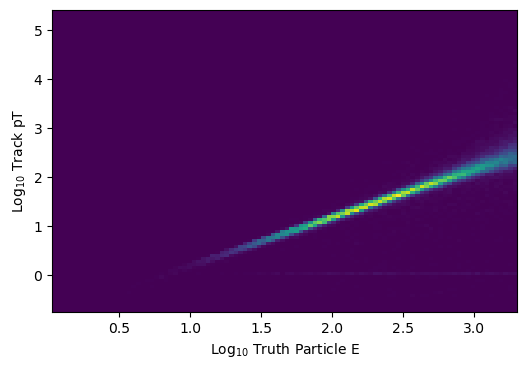

In [34]:
plt.figure(dpi=100)
plt.hist2d(df.log10_truth_particle_e, df.log10_track_pt, bins=100);
plt.xlabel(r'Log$_{10}$ Truth Particle E');
plt.ylabel(r'Log$_{10}$ Track pT');

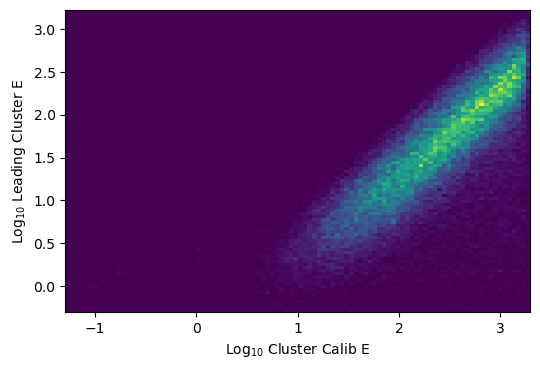

In [35]:
plt.figure(dpi=100)
plt.hist2d(df.log10_cluster_calib_e, df.log10_cluster_e_0, bins=100);
plt.xlabel(r'Log$_{10}$ Cluster Calib E');
plt.ylabel(r'Log$_{10}$ Leading Cluster E');

In [36]:
df["track_eta"] = df[['track_eta_0', 'track_eta_1','track_eta_2', 
                      'track_eta_3', 'track_eta_4', 'track_eta_5']].mean(axis=1)

In [37]:
df.track_eta.value_counts()

 0.000000e+00    1577
-3.973643e-08     548
 7.947286e-08     541
-7.947286e-08     525
 3.973643e-08     517
                 ... 
-5.149841e-05       1
-2.116921e+00       1
 1.287585e-05       1
-2.062569e-06       1
 2.272440e+00       1
Name: track_eta, Length: 16169, dtype: int64

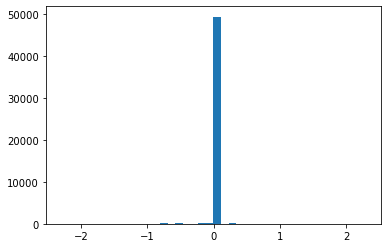

In [38]:
plt.hist(df[df.track_eta != 0].track_eta, bins=40);

In [42]:
train_vars = [
    'log10_cluster_e_0',
#     'log10_cluster_e_1',
#     'log10_cluster_e_2',
    'log10_track_pt',
    'track_eta',
#     'track_eta_0',
#     'track_eta_1',
#     'track_eta_2',
#     'track_eta_3',
#     'track_eta_4',
#     'track_eta_5',
             ]
# target_var = ['log10_cluster_calib_e'] # cluster-only target
target_var = ['log10_truth_particle_e'] # cluster + track target

In [43]:
test = train(df, train_vars, target_var, batch_size=32, epochs=10)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 50)                200       
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
Total params: 5,351
Trainable params: 5,351
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1055/1055 [==============================] - 2s 2ms/step - loss: 0.1805 - val_loss: 0.0190
Epoch 2/10
1055/1055 [==============================] - 2s 2ms/step - loss: 0.0176 - val_loss: 0.0168
Epoch 3/10
1055/1055 [========================

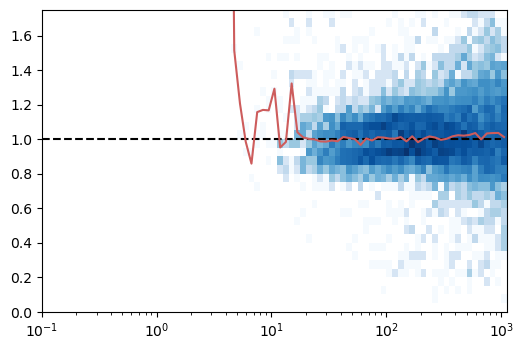

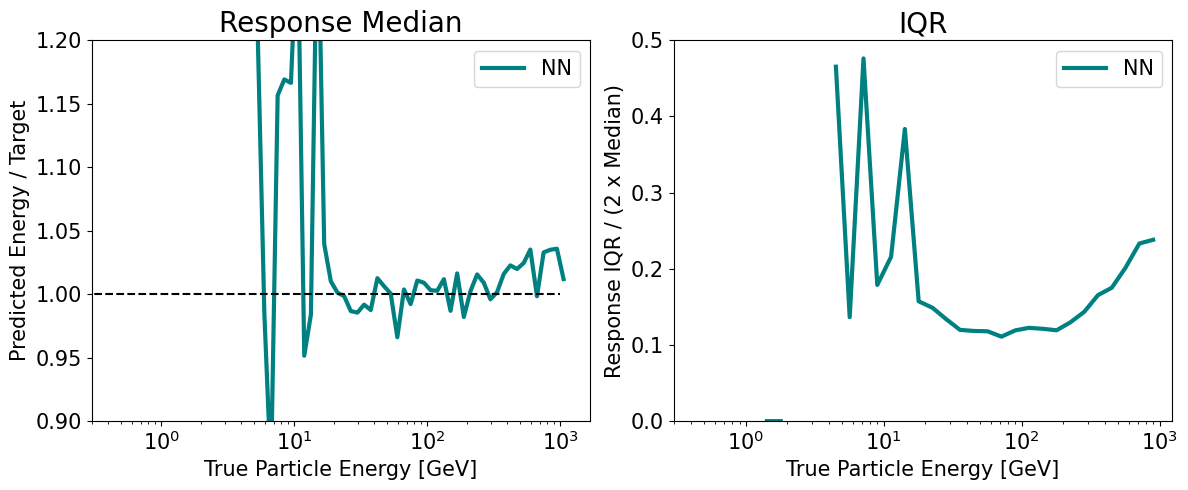

In [44]:
make_plots(test.nn_output, test.nn_target, plot_em=False, plot_track=False, 
#            save_label="dnn"
)

# or, train on everything, flattened

In [ ]:
### Load Russell's files 
x = np.load("../data/onetrack_multicluster/pion_files_russell/X_STMC_v2_20_files.npy")
y = np.load("../data/onetrack_multicluster/pion_files_russell/Y_STMC_v2_20_files.npy")

In [ ]:
x.shape

In [ ]:
x_energyonly = x[:,:,0]
x_energyonly = np.log10(x_energyonly)
x_energyonly = np.nan_to_num(x_energyonly, posinf=0, neginf=0)

In [ ]:
x_flattened = np.reshape(x, (x.shape[0], x.shape[1]*x.shape[2])) 
x_flattened[:,0::6] = np.log10(x_flattened[:,0::6]) # log of energy or pT
x_flattened = np.nan_to_num(x_flattened, posinf=0, neginf=0)

In [ ]:
x_flattened.shape

In [ ]:
# nonzero_cols = [i != 0 for i in np.sum(x_flattened, axis=0)]

In [ ]:
# x_flat_without_is_track = np.delete(x_flattened, np.arange(4, 8334, 6) , axis=1)

In [ ]:
### Test/train split 
train_index = np.random.choice(x.shape[0], int(0.8*x.shape[0]), replace=False)  
test_index = np.delete(np.arange(x.shape[0]), train_index)

train_x = x_energyonly[train_index]
train_y = np.log10(y[train_index,0])
test_x = x_energyonly[test_index]
test_y = np.log10(y[test_index,0])

In [ ]:
# ### Normalize the inputs 
sc = StandardScaler()
train_x = sc.fit_transform(train_x)
test_x = sc.transform(test_x)

In [ ]:
model = regression_model(train_x)

In [ ]:
history = model.fit(
    train_x,
    train_y,
    batch_size=32,
    validation_split=0.2,
    verbose=1, epochs=30,
#     callbacks=PlotLossesKeras()
)

### Evaluate performance on test set 
outputs, targets = model.predict(test_x), test_y

In [ ]:
make_plots(outputs[:,0], targets, plot_em=False, plot_track=False)